In [1]:
import tensorflow as tf
import os
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import csv
PH = 5

def readData(filePath) :
    x_data = []
    y_data = []
    allList = []
    newPointx=[]
    newPointy=[]
    
    with open(filePath, 'r') as f:
        for line in f:
            allList.append(float(line))
    
    df = pd.Series(allList) #일차원 리스트를 pandas 데이터프레임화
    while True:
        for i in df[0:7]: 
            newPointx.append(float(i)) #데이터프레임 앞의 7개를 newPointx 리스트에 삽입
        newPointy.append(float(df[7 + (PH/5)])) #데이터프레임 그 다음(10번째)을 newPointy 리스트에 삽입
        ########## 당화혈색소 인풋데이터 추가

        x_data.append(newPointx) #x_data 리스트에 newPointx 리스트를 삽입 (x_data는 array of array가 됨)
        y_data.append(newPointy) #위와 동일

        newPointx=[] #다음 반복을 위해 newPointx,y를 빈 리스트로 초기화
        newPointy=[]
        df=df.shift(-1) #데이터프레임 왼 쪽으로 1칸 쉬프트
        if(math.isnan(df[7 + (PH/5)])): #만약 8번째 데이터프레임이 NaN(Not a Number) 라면 반복 중지
            break

    #배열 갯수 보정작업
    #데이터의 개수가 항상 8의 배수가 아니기 때문에 x_data의 마지막 원소 리스트가 항상 7개가 아닐수 있고
    #y_data의 마지막 원소 리스트가 항상 1개가 아닐 수 있기 때문에 
    #빈 칸들은 0으로 채워주기 위한 작업
    if(len(x_data[-1]) != 7):
       xSize = 7-len(x_data[-1])
       for i in range(xSize):
           x_data[-1].append(0.0)
    if(len(y_data[-1])!=1):
       y_data[-1].append(0.0)  
    
    x_data = x_data
    data = [x_data, y_data]
    return data;


filename = os.listdir("github")

train_data_name = []
test_data_name = []

for fn in filename:
    if fn.find("test") != -1:
        test_data_name.append(fn)
    elif fn.find("train") != -1:
        train_data_name.append(fn)


#total_x_data = []
#total_y_data = []        
        
train_x_data = []
train_y_data = []

for fn in train_data_name:
    #if fn.find("885633") != -1:
        #print(fn+"제외")
    #elif fn.find("365303") != -1:
        #print(fn+"제외")
    #else:
    x,y = readData("github/"+str(fn))
    train_x_data.append(x)
    #total_x_data.append(x)
    train_y_data.append(y)
    #total_y_data.append(y)
    

test_x_data = []
test_y_data = []
for fn in test_data_name:
    #if fn.find("885633") != -1:
        #print(fn+"제외")
    #elif fn.find("365303") != -1:
        #print(fn+"제외")
    #else:
    x,y = readData("github/"+str(fn))
    test_x_data.append(x)
    #total_x_data.append(x)
    test_y_data.append(y)
    #total_y_data.append(y)

#print(test_x_data[6])

In [2]:
x = tf.placeholder(tf.float32,shape=[None,7])
y = tf.placeholder(tf.float32,shape=[None,1])

w1 = tf.Variable(tf.random_uniform([7,15],minval = -1 , maxval = 1,dtype=tf.float32))
b1 = tf.Variable(tf.zeros([1,15]))

w2 = tf.Variable(tf.random_uniform([15,30],minval = -1,maxval =1,dtype=tf.float32))
b2 = tf.Variable(tf.zeros([1,30]))

w3 = tf.Variable(tf.random_uniform([30,10],minval = -1,maxval = 1,dtype=tf.float32))
b3 = tf.Variable(tf.zeros([1,10]))

w4 = tf.Variable(tf.random_uniform([10,1],minval = -1,maxval = 1,dtype=tf.float32))
b4 = tf.Variable(tf.zeros([1,1]))

h1 = tf.add(tf.matmul(x,w1),b1)
h2 = tf.add(tf.matmul(h1,w2),b2)
h3 = tf.add(tf.matmul(h2,w3),b3)
func = tf.add(tf.matmul(h3,w4),b4)

rmse = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y, func))))

cost = tf.reduce_mean(tf.square(func-y))
optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
train = optimizer.minimize(cost)

sess =tf.Session()
sess.run(tf.global_variables_initializer())


for i in range(len(train_x_data)):
    for k in range(1000):
        sess.run(train,feed_dict={x:train_x_data[i],y:train_y_data[i]})


1번째 환자 rmse : 12.5988762608
전체 평균 rmse : 12.5988762608


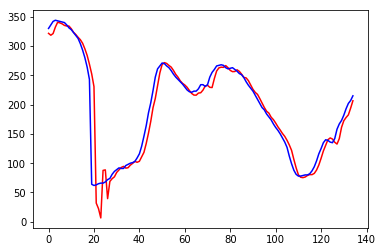

In [3]:
##그래프 출력 0번쨰 사람
predict = test_x_data[0]
pre_data = []
for i,k in enumerate(predict):
    pre = sess.run(func,feed_dict={x:[k]})
    pre_data.append(pre[0])

######rmse 출력
rmse_total = 0.0
rmse_one = 0.0
total_num = 0
one_person_num = 0
for size in range(len(test_x_data)):
    one_person_num = 0
    rmse_one = 0
    for i,k in enumerate(test_x_data[size]):
        total_num += 1
        one_person_num += 1
        rmse_total += sess.run(rmse,feed_dict={x:[k],y:[test_y_data[size][i]]})
        rmse_one += sess.run(rmse,feed_dict={x:[k],y:[test_y_data[size][i]]})
    print(str(size+1)+"번째 환자 rmse : "+str(rmse_one/float(one_person_num)))

rmse_total = rmse_total / float(total_num)
print("전체 평균 rmse : "+str(rmse_total))

plt.plot(pre_data,color="red")
plt.plot(test_y_data[0],color="blue")
plt.show()